# Import

In [1]:
import sys
sys.path.append("..")

from src.data import CrossSimilarityDataset
from src.utils import plot_cross_similarity
from src.transforms import RandomJumps
from src.asap import load_annotations, ASAPWrapper
from src.dcnn import DCNN
from src.trainer import Trainer

import os
from tqdm import tqdm

import numpy as np
import torch
from torch.utils.data import DataLoader
from torchvision.transforms.v2 import Resize
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

# Load dataset

In [3]:
# Path to the clonned ASAP repository

asap_dir = "../../asap-dataset"

In [4]:
asap_wrapper = ASAPWrapper(asap_dir, val_ratio=0.2, random_seed=42)

In [5]:
print(f'Number of performances in train: {len(asap_wrapper.train_paths)}')
print(f'Number of performances in val: {len(asap_wrapper.val_paths)}')

Number of performances in train: 836
Number of performances in val: 200


In [6]:
img_size = 256
fs = 10 # Sampling frequency
transform = Resize((img_size, img_size))
min_num_jumps = 0
max_num_jumps = 3
jumps_transform = RandomJumps(fs, min_num_jumps=min_num_jumps, max_num_jumps=max_num_jumps, max_silence_s=8.)

train_dataset = CrossSimilarityDataset(asap_wrapper.train_paths,
                                       fs,
                                       transform,
                                       structural_transform=jumps_transform,
                                       inference_only=False)

val_dataset = CrossSimilarityDataset(asap_wrapper.val_paths,
                                     fs,
                                     transform,
                                     structural_transform=jumps_transform,
                                     inference_only=False)

In [14]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)

val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)

/home/dmgvrlv/miniconda3/envs/dcnn/lib/python3.10/site-packages/pretty_midi/pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(
/home/dmgvrlv/miniconda3/envs/dcnn/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(anti

torch.Size([32, 1, 256, 256])
torch.Size([32, 6, 2])


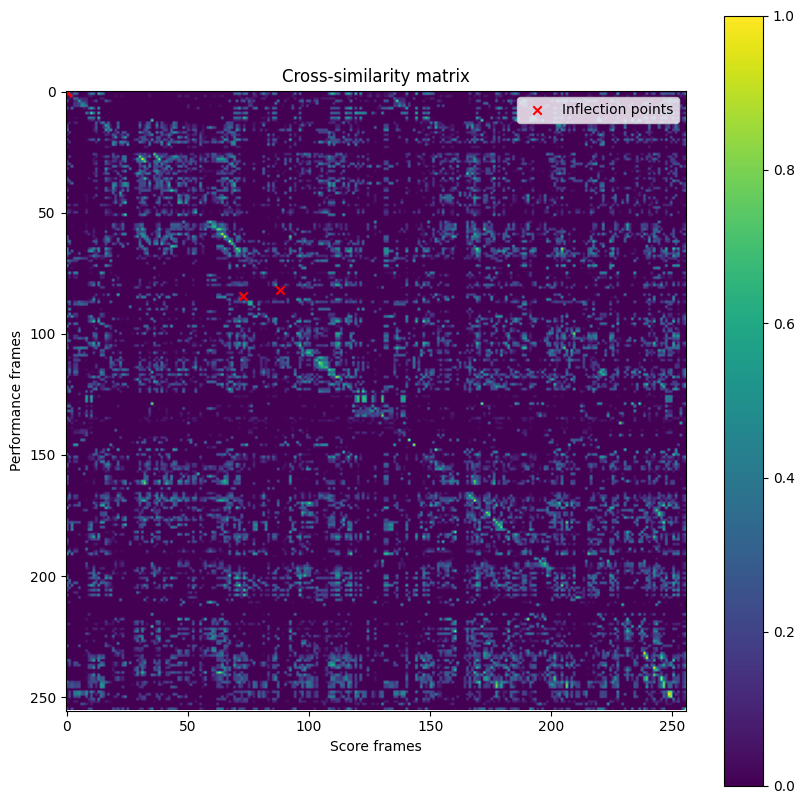

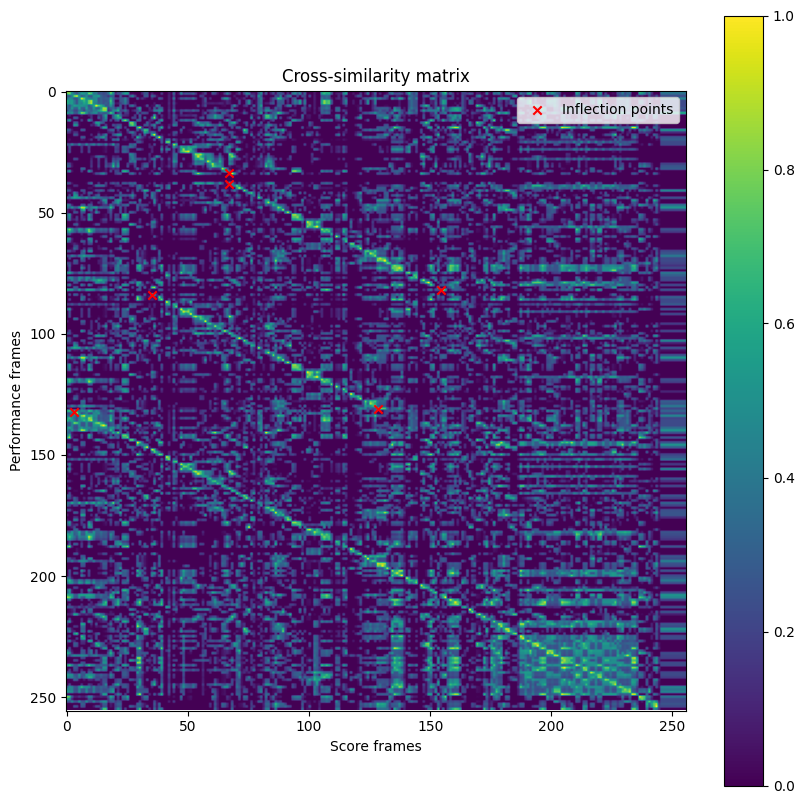

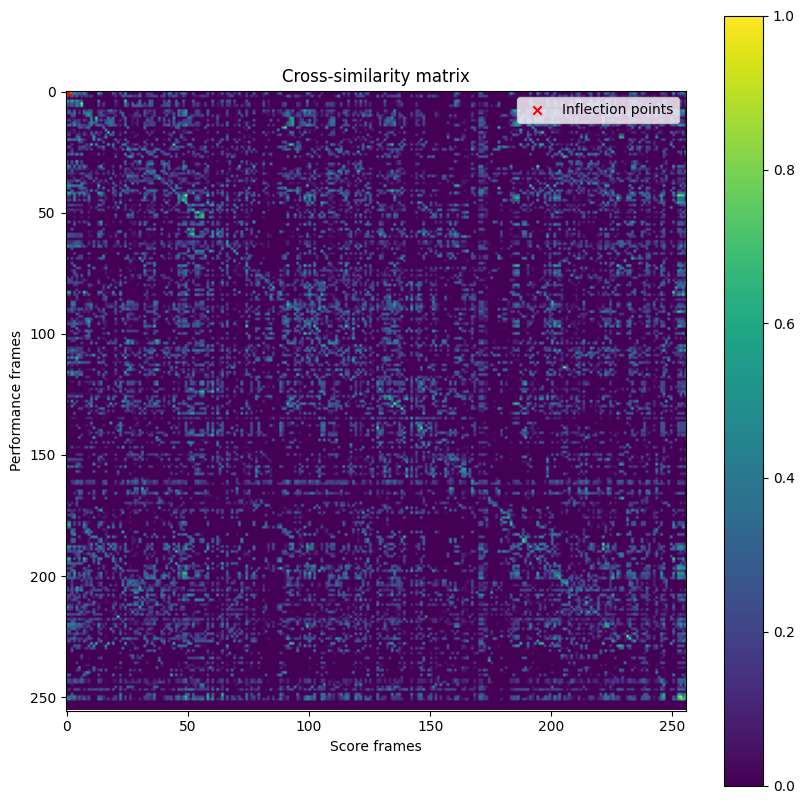

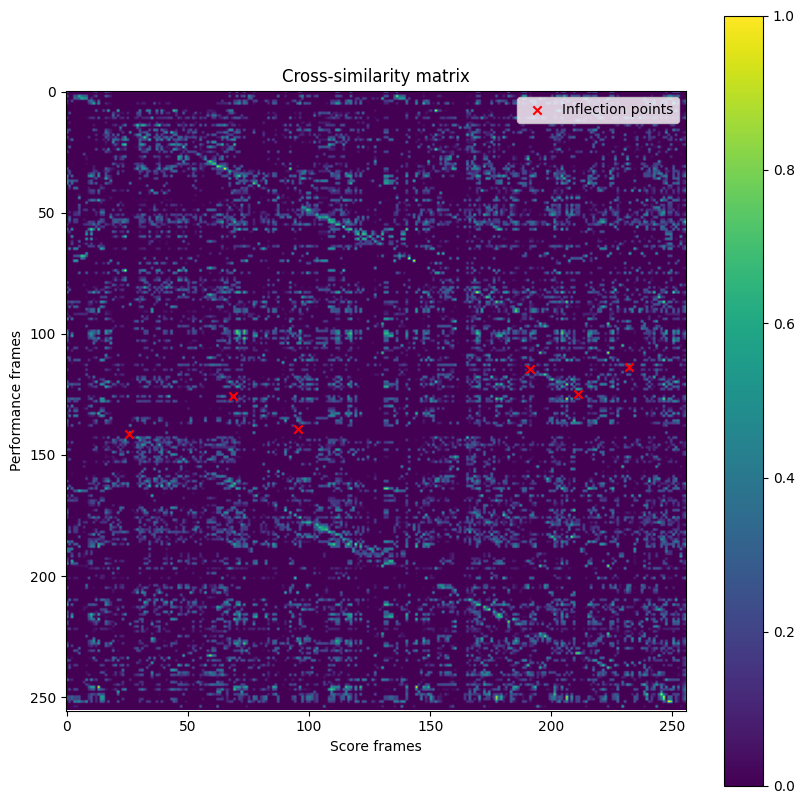

In [15]:
for batch in train_loader:
    x = batch['image']
    target = batch['target']
    for i in range(4):
        plot_cross_similarity(x[i],
                              beat_alignment=None,
                              inflection_points=target[i])
    print(x.shape)
    print(target.shape)
    break

# Model

In [16]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [17]:
model = DCNN(img_size, [2, 4, 8], max_num_jumps * 2).to(device)

In [18]:
from torch.optim import Adam

optimizer = Adam(model.parameters(), lr=1e-3)

num_epochs = 10

In [19]:
trainer = Trainer(train_loader,
                  val_loader,
                  num_epochs,
                  optimizer,
                  device)

In [20]:
trainer.train(model)

  0%|          | 0/27 [00:00<?, ?it/s]/home/dmgvrlv/miniconda3/envs/dcnn/lib/python3.10/site-packages/pretty_midi/pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(
/home/dmgvrlv/miniconda3/envs/dcnn/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: upda

Epoch: 0, Train loss: 15.182644329965115


  0%|          | 0/7 [00:00<?, ?it/s]/home/dmgvrlv/miniconda3/envs/dcnn/lib/python3.10/site-packages/pretty_midi/pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(
/home/dmgvrlv/miniconda3/envs/dcnn/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: updat

Epoch: 0, Val loss: 0.8657230287790298


  0%|          | 0/27 [00:00<?, ?it/s]/home/dmgvrlv/miniconda3/envs/dcnn/lib/python3.10/site-packages/pretty_midi/pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(
/home/dmgvrlv/miniconda3/envs/dcnn/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: upda

Epoch: 1, Train loss: 3.4639187082648277


  0%|          | 0/7 [00:00<?, ?it/s]/home/dmgvrlv/miniconda3/envs/dcnn/lib/python3.10/site-packages/pretty_midi/pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(
/home/dmgvrlv/miniconda3/envs/dcnn/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: updat

Epoch: 1, Val loss: 0.8194745630025864


  0%|          | 0/27 [00:00<?, ?it/s]/home/dmgvrlv/miniconda3/envs/dcnn/lib/python3.10/site-packages/pretty_midi/pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(
/home/dmgvrlv/miniconda3/envs/dcnn/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: upda

Epoch: 2, Train loss: 3.271053232252598


  0%|          | 0/7 [00:00<?, ?it/s]/home/dmgvrlv/miniconda3/envs/dcnn/lib/python3.10/site-packages/pretty_midi/pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(
/home/dmgvrlv/miniconda3/envs/dcnn/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: updat

Epoch: 2, Val loss: 0.850131444633007


  0%|          | 0/27 [00:00<?, ?it/s]/home/dmgvrlv/miniconda3/envs/dcnn/lib/python3.10/site-packages/pretty_midi/pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(
/home/dmgvrlv/miniconda3/envs/dcnn/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: upda

Epoch: 3, Train loss: 3.466956250369549


  0%|          | 0/7 [00:00<?, ?it/s]/home/dmgvrlv/miniconda3/envs/dcnn/lib/python3.10/site-packages/pretty_midi/pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(
/home/dmgvrlv/miniconda3/envs/dcnn/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: updat

Epoch: 3, Val loss: 0.9771295711398125


  0%|          | 0/27 [00:00<?, ?it/s]/home/dmgvrlv/miniconda3/envs/dcnn/lib/python3.10/site-packages/pretty_midi/pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(
/home/dmgvrlv/miniconda3/envs/dcnn/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: upda

Epoch: 4, Train loss: 3.245912067592144


  0%|          | 0/7 [00:00<?, ?it/s]/home/dmgvrlv/miniconda3/envs/dcnn/lib/python3.10/site-packages/pretty_midi/pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(
/home/dmgvrlv/miniconda3/envs/dcnn/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: updat

Epoch: 4, Val loss: 0.8590180799365044


  0%|          | 0/27 [00:00<?, ?it/s]/home/dmgvrlv/miniconda3/envs/dcnn/lib/python3.10/site-packages/pretty_midi/pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(
/home/dmgvrlv/miniconda3/envs/dcnn/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: upda

Epoch: 5, Train loss: 3.2006601486355066


  0%|          | 0/7 [00:00<?, ?it/s]/home/dmgvrlv/miniconda3/envs/dcnn/lib/python3.10/site-packages/pretty_midi/pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(
/home/dmgvrlv/miniconda3/envs/dcnn/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: updat

Epoch: 5, Val loss: 0.827366404235363


  0%|          | 0/27 [00:00<?, ?it/s]/home/dmgvrlv/miniconda3/envs/dcnn/lib/python3.10/site-packages/pretty_midi/pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(
/home/dmgvrlv/miniconda3/envs/dcnn/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: upda

Epoch: 6, Train loss: 3.4372707828879356


  0%|          | 0/7 [00:00<?, ?it/s]/home/dmgvrlv/miniconda3/envs/dcnn/lib/python3.10/site-packages/pretty_midi/pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(
/home/dmgvrlv/miniconda3/envs/dcnn/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: updat

Epoch: 6, Val loss: 0.924906887114048


  0%|          | 0/27 [00:00<?, ?it/s]/home/dmgvrlv/miniconda3/envs/dcnn/lib/python3.10/site-packages/pretty_midi/pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(
/home/dmgvrlv/miniconda3/envs/dcnn/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: upda

Epoch: 7, Train loss: 3.3337696865200996


  0%|          | 0/7 [00:00<?, ?it/s]/home/dmgvrlv/miniconda3/envs/dcnn/lib/python3.10/site-packages/pretty_midi/pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(
/home/dmgvrlv/miniconda3/envs/dcnn/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: updat

Epoch: 7, Val loss: 0.9196465387940407


  0%|          | 0/27 [00:00<?, ?it/s]/home/dmgvrlv/miniconda3/envs/dcnn/lib/python3.10/site-packages/pretty_midi/pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(
/home/dmgvrlv/miniconda3/envs/dcnn/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: upda

Epoch: 8, Train loss: 3.0593163445591927


  0%|          | 0/7 [00:00<?, ?it/s]/home/dmgvrlv/miniconda3/envs/dcnn/lib/python3.10/site-packages/pretty_midi/pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(
/home/dmgvrlv/miniconda3/envs/dcnn/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: updat

Epoch: 8, Val loss: 0.8693641349673271


  0%|          | 0/27 [00:00<?, ?it/s]/home/dmgvrlv/miniconda3/envs/dcnn/lib/python3.10/site-packages/pretty_midi/pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(
/home/dmgvrlv/miniconda3/envs/dcnn/lib/python3.10/site-packages/pretty_midi/pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(
/home/dmgvrlv/miniconda3/envs/dcnn/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass anti

Epoch: 9, Train loss: 3.010746542364359


  0%|          | 0/7 [00:00<?, ?it/s]/home/dmgvrlv/miniconda3/envs/dcnn/lib/python3.10/site-packages/pretty_midi/pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(
/home/dmgvrlv/miniconda3/envs/dcnn/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: updat

Epoch: 9, Val loss: 0.9201649576425552


/home/dmgvrlv/miniconda3/envs/dcnn/lib/python3.10/site-packages/pretty_midi/pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(
/home/dmgvrlv/miniconda3/envs/dcnn/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(anti

torch.Size([32, 1, 256, 256])
torch.Size([32, 6, 2])


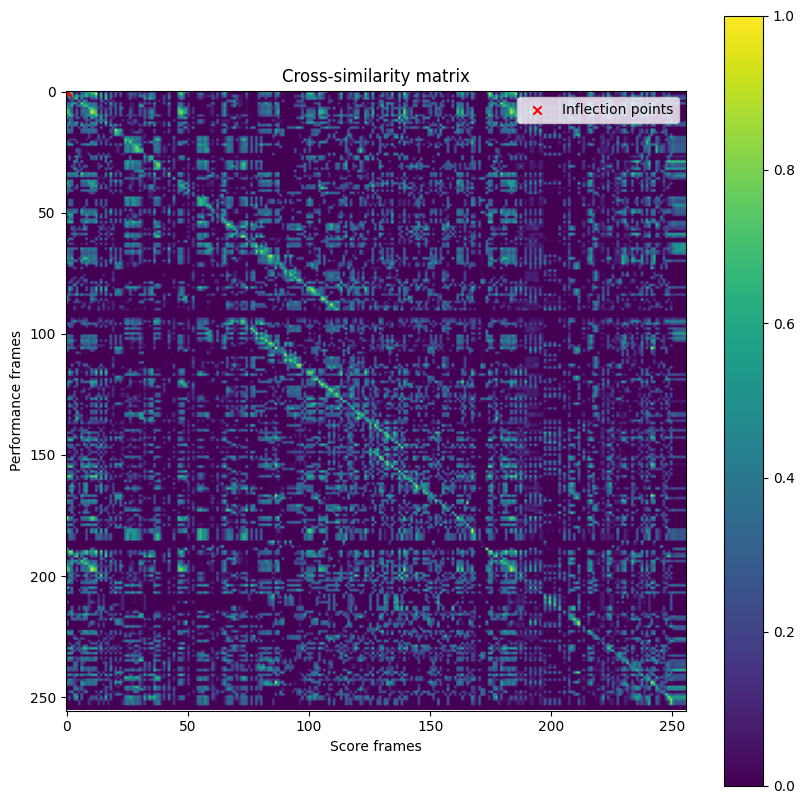

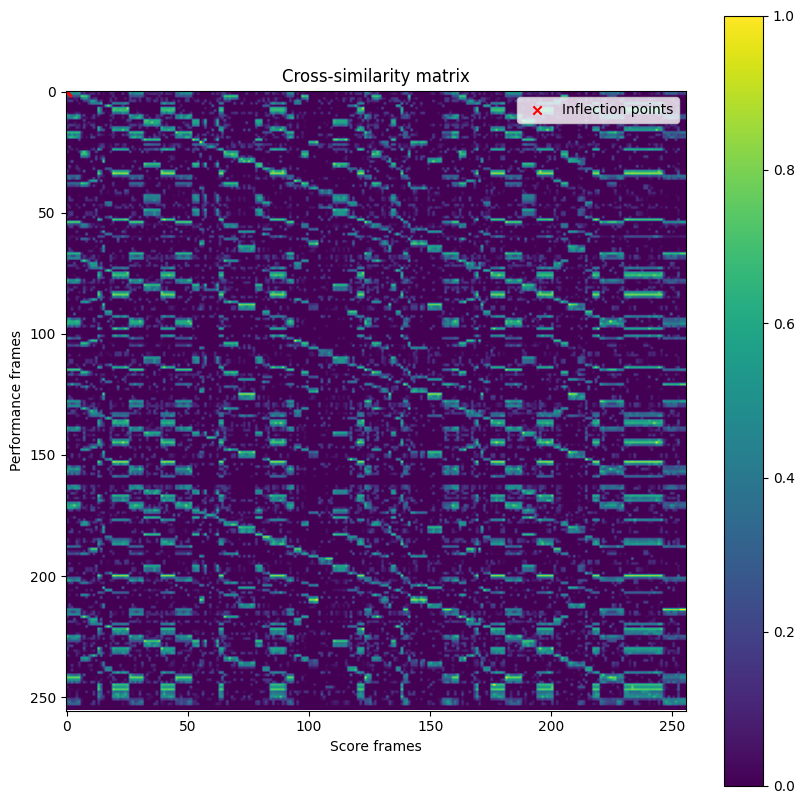

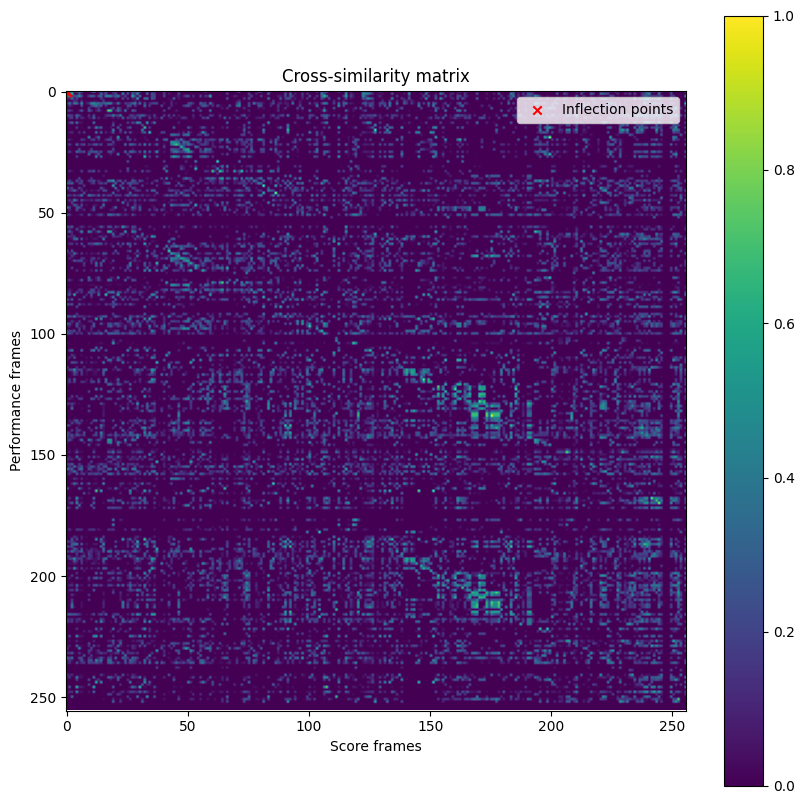

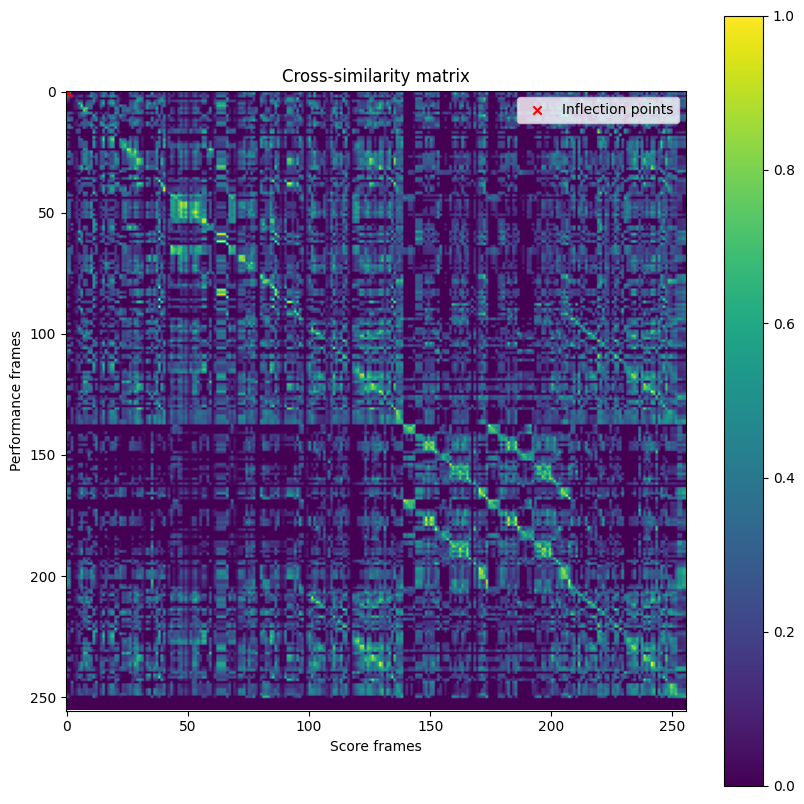

In [26]:
for batch in train_loader:
    x = batch['image'].to(device)
    y_true = batch['target'].to(device)
    model.eval()
    with torch.no_grad():
        y_pred = model(x).cpu()
    x = x.cpu()
    for i in range(4):
        plot_cross_similarity(x[i],
                              beat_alignment=None,
                              inflection_points=y_pred[i])
    print(x.shape)
    print(target.shape)
    break

In [27]:
y_pred

tensor([[[0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000]],

        [[0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000]],

        [[0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000]],

        [[0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000]],

        [[0.0000, 0.9383],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000]],

        [[0.0000, 0.6520],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000]],

        [[0.0000